# CNN
Training auf IDS18 80%  
Validierung auf IDS18 10%   
Test auf IDS18 10%  
Test auf IDS17 mit reduzierten Benign Daten folgt in cnn_test

In [ ]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

2024-10-30 11:03:40.362539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 11:03:40.369803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 11:03:40.378014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 11:03:40.380371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 11:03:40.386848: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnisse der Datensätze
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS18

In [ ]:
# IDS18 Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
ids18 = pd.read_parquet(os.path.join(parquet_verzeichnis_ids18 + '_prep_0'))
logging.info("Class distribution\n{}".format(ids18.Label.value_counts()))

2024-10-30 11:04:13 - INFO - Class distribution
Label
BENIGN                                          5935340
DoS Hulk                                        1803160
DDoS-LOIC-HTTP                                   289328
Botnet Ares                                      142921
SSH-BruteForce                                    94197
Infiltration - NMAP Portscan                      89374
DoS GoldenEye                                     22560
DoS Slowloris                                      8490
Web Attack - Brute Force                            131
Web Attack - XSS                                    113
Web Attack - SQL                                     39
Infiltration - Communication Victim Attacker          0
Infiltration - Dropbox Download                       0
Infiltration - Dropbox Download - Attempted           0
FTP-BruteForce - Attempted                            0
Botnet Ares - Attempted                               0
DDoS-HOIC                                         

In [ ]:
print(ids18.shape)
print(ids18.columns)

### Trennen von Features und Labels

In [ ]:
X = ids18.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = ids18.iloc[:, -1]   # Die letzte Spalte 'Label' ist die Zielvariable
print("Form von y:", y.shape)


Form von X: (8385653, 83)
Form von y: (8385653,)


### Label Encoding für y

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

### Skallierung von X

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

### Umformen der Daten für das CNN

In [12]:
# Anzahl der Features
num_features = X_scaled.shape[1]  # Sollte 83 sein

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_reshaped = X_scaled.reshape(-1, num_features, 1)
print("Form von X_reshaped:", X_reshaped.shape)  # Erwartet: (1923167, 83, 1)

Form von X_reshaped: (8385653, 83, 1)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [13]:
# Aufteilen in Trainings- und temporären Datensatz
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reshaped, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen des temporären Datensatzes in Validierung und Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)

Form von X_train: (6708522, 83, 1)
Form von X_val: (838565, 83, 1)
Form von X_test: (838566, 83, 1)


### Überprüfen der Klassenverteilung

In [14]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 4748272 Beispiele (70.78%)
  Klasse 1: 114337 Beispiele (1.70%)
  Klasse 2: 231462 Beispiele (3.45%)
  Klasse 3: 18048 Beispiele (0.27%)
  Klasse 4: 1442528 Beispiele (21.50%)
  Klasse 5: 6792 Beispiele (0.10%)
  Klasse 6: 71499 Beispiele (1.07%)
  Klasse 7: 75358 Beispiele (1.12%)
  Klasse 8: 105 Beispiele (0.00%)
  Klasse 9: 31 Beispiele (0.00%)
  Klasse 10: 90 Beispiele (0.00%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 593534 Beispiele (70.78%)
  Klasse 1: 14292 Beispiele (1.70%)
  Klasse 2: 28933 Beispiele (3.45%)
  Klasse 3: 2256 Beispiele (0.27%)
  Klasse 4: 180316 Beispiele (21.50%)
  Klasse 5: 849 Beispiele (0.10%)
  Klasse 6: 8937 Beispiele (1.07%)
  Klasse 7: 9419 Beispiele (1.12%)
  Klasse 8: 13 Beispiele (0.00%)
  Klasse 9: 4 Beispiele (0.00%)
  Klasse 10: 12 Beispiele (0.00%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 593534 Beispiele (70.78%)
  Klasse 1: 14292 Beispiele (1.70%)
  Klasse 2: 28933 Bei

 ### Modell erstellen und trainieren

In [15]:
def create_cnn_model(num_features, num_classes):
    inputs = keras.layers.Input(shape=(num_features, 1))
    x = keras.layers.Conv1D(120, kernel_size=2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv1D(60, kernel_size=3, activation='relu', padding="same")(x)
    x = keras.layers.Conv1D(30, kernel_size=4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Kompilieren des Modells
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

# Anzahl der Klassen (Labels)
num_classes = len(label_encoder.classes_)

# Modell erstellen
cnn_model = create_cnn_model(num_features, num_classes)
cnn_model.summary()


I0000 00:00:1730282805.402213  784352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730282805.502753  784352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730282805.502974  784352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730282805.513991  784352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730282805.514303  784352 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 83, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 83, 120)        │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 83, 60)         │        21,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 83, 30)         │         7,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2490)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │        27,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,651 (221.29 KB)

 Trainable params: 56,651 (221.29 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [16]:
cnn_model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/2


I0000 00:00:1730282818.175726  785069 service.cc:146] XLA service 0x7f75a00164c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730282818.175988  785069 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-10-30 11:06:58.209272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 11:06:58.316671: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   131/209642 ━━━━━━━━━━━━━━━━━━━━ 4:04 1ms/step - loss: 0.7218 - sparse_categorical_accuracy: 0.8376  

I0000 00:00:1730282820.100981  785069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


209642/209642 ━━━━━━━━━━━━━━━━━━━━ 293s 1ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0016 - val_sparse_categorical_accuracy: 0.9998
Epoch 2/2
209642/209642 ━━━━━━━━━━━━━━━━━━━━ 291s 1ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0011 - val_sparse_categorical_accuracy: 0.9997


### Evaluierung des Modells auf dem Testdatensatz

In [17]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

26206/26206 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 0.0010 - sparse_categorical_accuracy: 0.9997
Testverlust: 0.0011
Testgenauigkeit: 0.9997


### Klassifikationsbericht und eine Konfusionsmatrix

In [18]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Konfusionsmatrix:")
print(cm)

26206/26206 ━━━━━━━━━━━━━━━━━━━━ 17s 662us/step


/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    593534
                 Botnet Ares       1.00      1.00      1.00     14292
              DDoS-LOIC-HTTP       1.00      1.00      1.00     28933
               DoS GoldenEye       1.00      1.00      1.00      2256
                    DoS Hulk       1.00      1.00      1.00    180316
               DoS Slowloris       1.00      1.00      1.00       849
Infiltration - NMAP Portscan       1.00      0.98      0.99      8938
              SSH-BruteForce       1.00      1.00      1.00      9420
    Web Attack - Brute Force       1.00      1.00      1.00        13
            Web Attack - SQL       0.00      0.00      0.00         4
            Web Attack - XSS       1.00      1.00      1.00        11

                    accuracy                           1.00    838566
                   macro avg       0.91      0.91      0.91    838566
                we

/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualisierung der Konfusionsmatrix

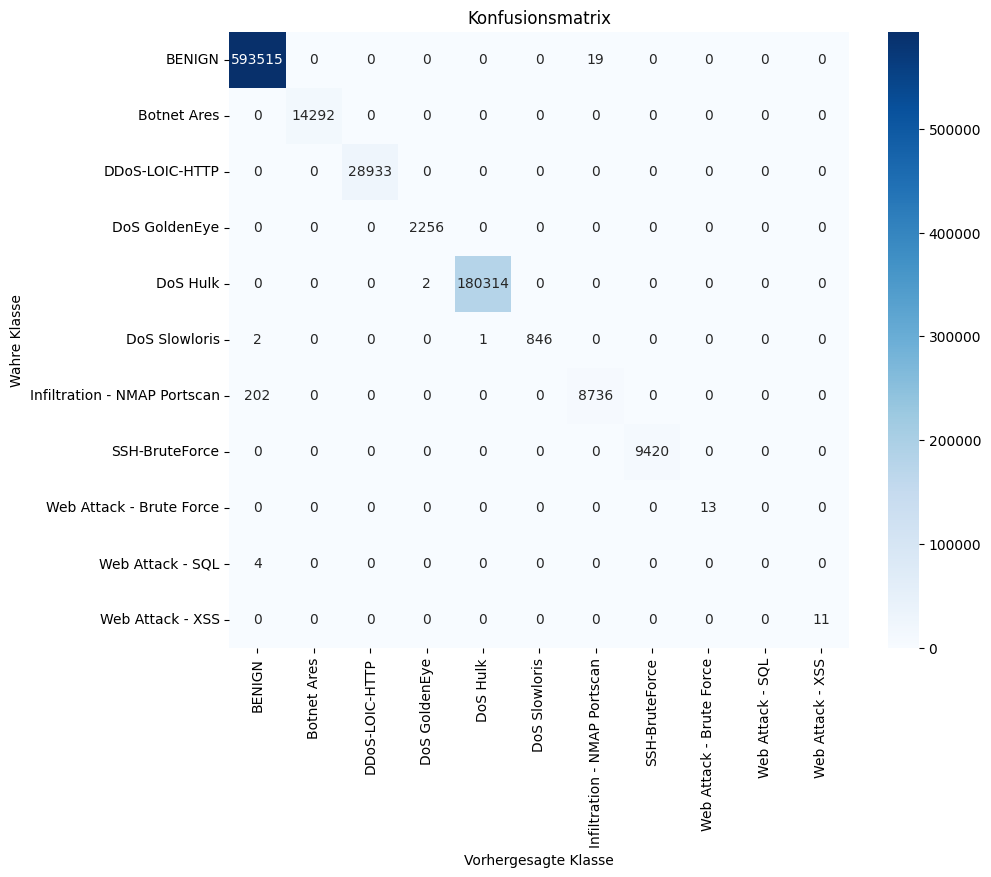

In [19]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [20]:
# Speichern des Modells
cnn_model.save('ids18_cnn_model.h5')

# Speichern des Label Encoders und Scalers
import joblib

joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

2024-10-30 11:19:57 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


['scaler.pkl']